In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pylab as plt
import copy
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [77]:
df = pd.read_csv('../data/Class Prediction Processed.csv', index_col = None)
df.drop(columns = "Unnamed: 0", inplace = True)
df.head()

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0.545320,0.634610,0.258055,0.627813,0.520383,0.344384,0.485403,0.678388,0.327415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.552902,0.637601,0.270018,0.502106,0.670846,0.430027,0.629502,0.535526,0.254553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.550633,0.638358,0.267404,0.498287,0.671194,0.426297,0.626890,0.536690,0.251666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.548890,0.635509,0.262714,0.493536,0.668331,0.418368,0.653507,0.628324,0.244963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.548263,0.634493,0.260681,0.492251,0.667160,0.415697,0.621934,0.532450,0.243484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing Value

The reason why missing values exist is that the markers are placed on finger nails and nuckles, they may not be detected by the camera in certain gestures. For example, when the gesture is a fist, the camera can only capture 7 markers at most (5 nuckles connecting fingers with the palm and nail and joint of thumb), as shown in the picture below. 
<img src="../figures/fist_1.png" alt="drawing" width="200"/>

In addition, the $i$-th marker of a given record does not necessarily correspond to the $i$-th marker of a different record. One may randomly permute the visible (i.e. not missing) markers of a given record without changing the set that the record represents.

This means that the bigger $i$ is, the more likely the value will be missing.  

### Status of missing value according to different classes

The table below also shows the same result: the bigger $i$ is, the more likely the value will be missing.  

In [78]:
df_0 = df[df["Class"] == 0]
df_1 = df[df["Class"] == 1]
df_2 = df[df["Class"] == 2]
df_3 = df[df["Class"] == 3]
df_4 = df[df["Class"] == 4]

missing_stats = {}

for i in range(0, 5):
    missing_stats[i] = df[df["Class"] == i].isnull().sum(axis=0)/df[df["Class"] == i].shape[0]
    
missing_stats = pd.DataFrame.from_dict(missing_stats)
missing_stats

,0,1,2,3,4
Class,0.000000,0.000000,0.000000,0.000000,0.000000
X0,0.000000,0.000000,0.000000,0.000000,0.000000
Y0,0.000000,0.000000,0.000000,0.000000,0.000000
Z0,0.000000,0.000000,0.000000,0.000000,0.000000
X1,0.000000,0.000000,0.000000,0.000000,0.000000
Y1,0.000000,0.000000,0.000000,0.000000,0.000000
Z1,0.000000,0.000000,0.000000,0.000000,0.000000
X2,0.000000,0.000000,0.000000,0.000000,0.000000
Y2,0.000000,0.000000,0.000000,0.000000,0.000000
Z2,0.000000,0.000000,0.000000,0.000000,0.000000


### How many markers are missing?

A new column is added to DataFrame indicating how many markers are missing in each data point.  

In [79]:
df['Missing_marker_num'] = df.isnull().sum(axis=1)
df[['Missing_marker_num']].head()

,Missing_marker_num
0,21
1,21
2,21
3,21
4,21


### Impute and drop missing values

Some features miss more than 30% of values, and according to the reason why values are missing is this dataset, it would be biased to impute them, and because all data points contain missing data in one way or another, it is impossible to remove data points as well. Therefore, given that I have created a new feature on how many markers are missing, it is acceptable to drop features with too much missing value.  

So in the end, the features I kept are $X0, Y0, Z0, \ldots, X4, Y4, Z4, Missing\_marker\_num$, 16 features in total.  

Missing value in $X0, Y0, Z0, \ldots, X4, Y4, Z4$ are then imputed using random forest.  

In [80]:
impute_feat = list(df.columns[0:16])
impute_feat.append("Missing_marker_num")
impute_feat

['Class',
 'X0',
 'Y0',
 'Z0',
 'X1',
 'Y1',
 'Z1',
 'X2',
 'Y2',
 'Z2',
 'X3',
 'Y3',
 'Z3',
 'X4',
 'Y4',
 'Z4',
 'Missing_marker_num']

In [81]:
X = df[impute_feat].values

imputer = IterativeImputer(estimator = RandomForestRegressor(max_depth = 8, n_estimators = 32), random_state=1)
X_impute = imputer.fit_transform(X)

df[impute_feat] = X_impute

df.to_csv("../data/Class_Pred_Imputed_Data_v3.csv")

In [166]:
df_imp = pd.read_csv("../data/Class_Pred_Imputed_Data_v3.csv")
df_imp.drop(columns = "Unnamed: 0", inplace = True)
df_imp.drop(columns = df.columns[17:38], inplace = True)
display(df_imp.head())

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,Missing_marker_num
0,0.0,0.545320,0.634610,0.258055,0.627813,0.520383,0.344384,0.485403,0.678388,0.327415,0.749610,0.621871,0.256018,0.583293,0.408057,0.310745,21.0
1,0.0,0.552902,0.637601,0.270018,0.502106,0.670846,0.430027,0.629502,0.535526,0.254553,0.758052,0.624321,0.266940,0.592133,0.412193,0.319682,21.0
2,0.0,0.550633,0.638358,0.267404,0.498287,0.671194,0.426297,0.626890,0.536690,0.251666,0.755710,0.626229,0.265348,0.592497,0.412243,0.319458,21.0
3,0.0,0.548890,0.635509,0.262714,0.493536,0.668331,0.418368,0.653507,0.628324,0.244963,0.659668,0.409387,0.273345,0.650352,0.528410,0.308150,21.0
4,0.0,0.548263,0.634493,0.260681,0.492251,0.667160,0.415697,0.621934,0.532450,0.243484,0.753934,0.622443,0.260561,0.590983,0.408666,0.318045,21.0


## EDA

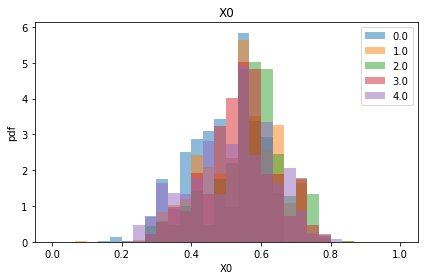

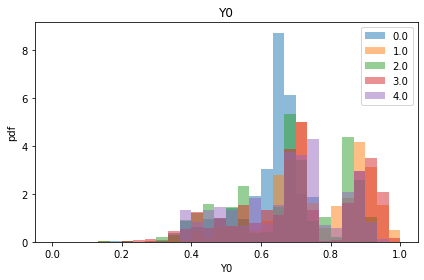

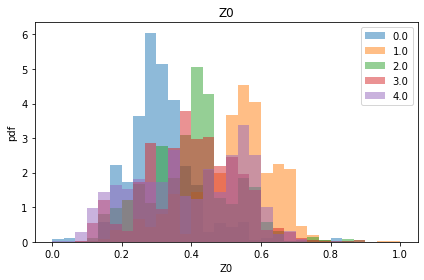

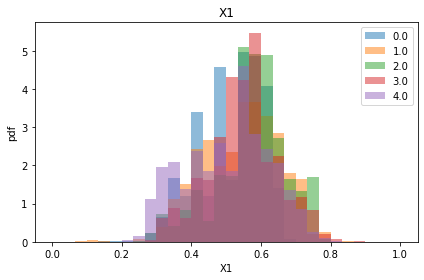

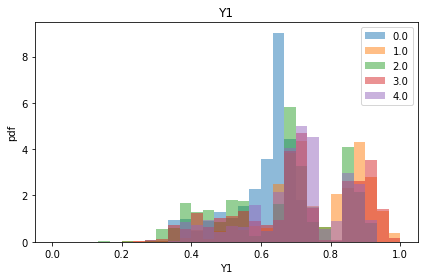

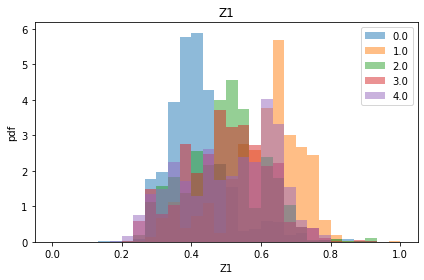

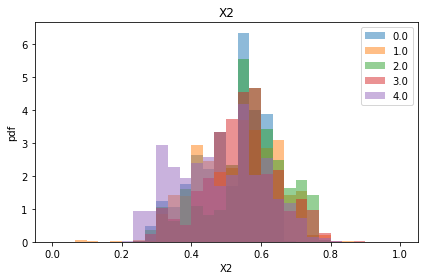

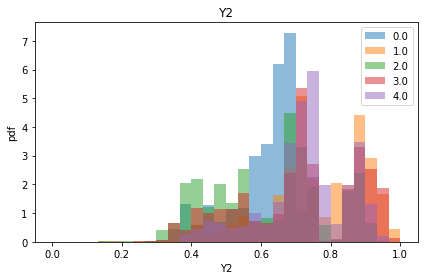

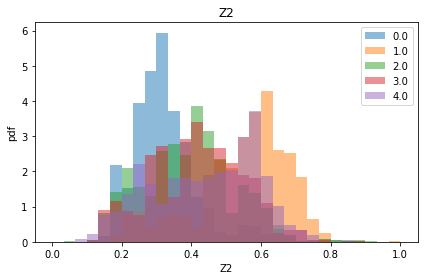

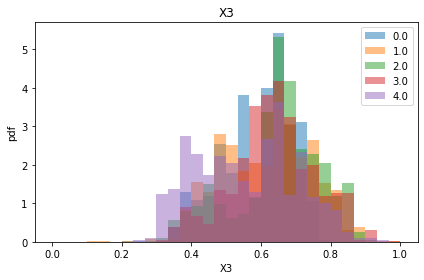

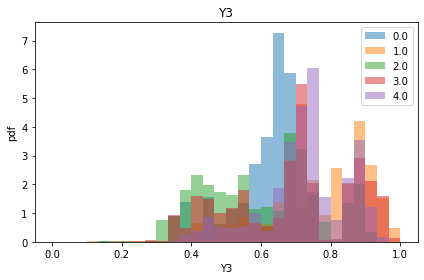

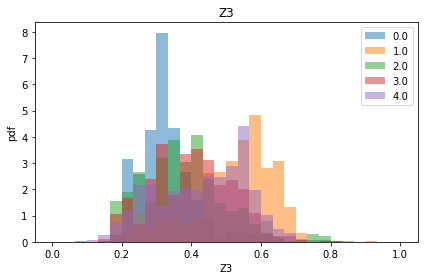

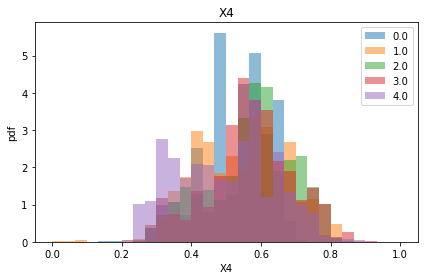

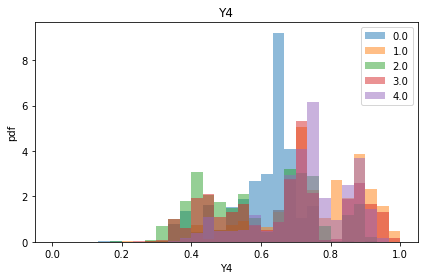

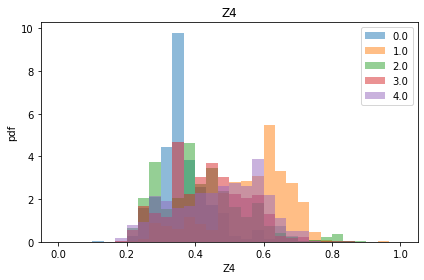

In [167]:
cont = df_imp.columns[1:16]
cont

for i in cont:
    categories = df['Class'].unique()
    bin_range = (df[i].min(),df[i].max())
    for c in categories:
        plt.hist(df[df['Class']==c][i],alpha=0.5,label=c,
                 range=bin_range,bins=30,density=True)
    plt.title(i)
    plt.legend(set(df['Class']))
    plt.ylabel('pdf')
    plt.xlabel(i)
    plt.tight_layout()
    plt.show()

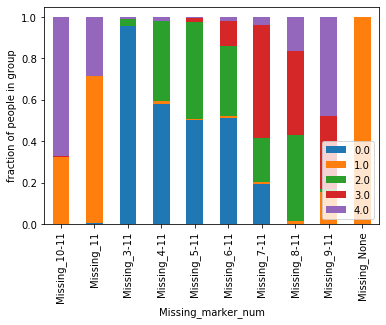

In [168]:
df_imp['Missing_marker_num'] = df_imp['Missing_marker_num'].replace(0.0, "Missing_None")
df_imp['Missing_marker_num'] = df_imp['Missing_marker_num'].replace(3.0, "Missing_11")
for i in range(6, 30, 3):
    df_imp['Missing_marker_num'] = df_imp['Missing_marker_num'].replace(float(i), f"Missing_{(11 - int(i/3) + 1)}-11")

count_matrix = df_imp.groupby(["Missing_marker_num", "Class"]).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc = 'lower right')
plt.show()

After inspection, I found that $Missing\_marker\_num$ is actually an ordinal categorical feature, so OrdinalEncoder is used to preprocess it.  

In [169]:
set(df_imp['Missing_marker_num'])

{'Missing_10-11',
 'Missing_11',
 'Missing_3-11',
 'Missing_4-11',
 'Missing_5-11',
 'Missing_6-11',
 'Missing_7-11',
 'Missing_8-11',
 'Missing_9-11',
 'Missing_None'}

In [170]:
ordinal_cats = [['Missing_None', 'Missing_11', 'Missing_10-11', 'Missing_9-11', 'Missing_8-11', 
                 'Missing_7-11', 'Missing_6-11', 'Missing_5-11', 'Missing_4-11', 'Missing_3-11']]
oe = OrdinalEncoder(categories = ordinal_cats)
oe_values = oe.fit_transform(df_imp[["Missing_marker_num"]])
df_imp_ordinal = pd.DataFrame(data=oe_values,columns = ["Missing_marker_num"])


# ohe = OneHotEncoder(sparse=False)
# cat_values = ohe.fit_transform(df_imp[["Missing_marker_num"]])
# cat_ftr_names = ohe.get_feature_names()
# df_imp_cat = pd.DataFrame(data=cat_values,columns = cat_ftr_names)
df_imp.drop(columns = ['Missing_marker_num'], inplace = True)
df_imp = pd.concat([df_imp,df_imp_ordinal],axis=1)
print(df_imp.columns)
print(set(df_imp['Missing_marker_num']))
df_imp.to_csv('../data/Class_Pred_Final_Data_v3.csv')
df_imp.head()

Index(['Class', 'X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2', 'X3',
       'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'Missing_marker_num'],
      dtype='object')
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}


,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,Missing_marker_num
0,0.0,0.545320,0.634610,0.258055,0.627813,0.520383,0.344384,0.485403,0.678388,0.327415,0.749610,0.621871,0.256018,0.583293,0.408057,0.310745,7.0
1,0.0,0.552902,0.637601,0.270018,0.502106,0.670846,0.430027,0.629502,0.535526,0.254553,0.758052,0.624321,0.266940,0.592133,0.412193,0.319682,7.0
2,0.0,0.550633,0.638358,0.267404,0.498287,0.671194,0.426297,0.626890,0.536690,0.251666,0.755710,0.626229,0.265348,0.592497,0.412243,0.319458,7.0
3,0.0,0.548890,0.635509,0.262714,0.493536,0.668331,0.418368,0.653507,0.628324,0.244963,0.659668,0.409387,0.273345,0.650352,0.528410,0.308150,7.0
4,0.0,0.548263,0.634493,0.260681,0.492251,0.667160,0.415697,0.621934,0.532450,0.243484,0.753934,0.622443,0.260561,0.590983,0.408666,0.318045,7.0
